# 2d Shell Q16

In [1]:
Lx = 600.0
Ly = 800.0
nx = 12
ny = 16
E = 2860.0
nu = 0.2
t = 25.0
Fz = -10.0

## Custom Isoparametric Element

In [2]:
from typing import Tuple, List

import numpy as np
from sympy import symbols

from neumann.numint import gauss_points as gp

from polymesh.grid import grid
from polymesh.polygon import PolyGon

from sigmaepsilon.fem.material import MindlinShell
from sigmaepsilon.fem.cells.elem import FiniteElement
from sigmaepsilon.fem.cells.meta import ABCFiniteElement as ABC


class Q16_S_MR(ABC, MindlinShell, PolyGon, FiniteElement):
    NNODE = 16

    qrule = "selective"
    quadrature = {
        "full": gp(4, 4),
        "selective": {(0, 1, 3, 4, 5): "full", (2, 6, 7): "reduced"},
        "reduced": gp(3, 3),
    }

    @classmethod
    def polybase(cls) -> Tuple[List]:
        locvars = r, s = symbols("r s", real=True)
        monoms = [1]
        monoms += [r, s]
        monoms += [r**2, s**2, r * s]
        monoms += [r * s**2, s * r**2, r**3, s**3]
        monoms += [r**2 * s**2, r**3 * s, r * s**3]
        monoms += [r**3 * s**2, r**2 * s**3]
        monoms += [r**3 * s**3]
        return locvars, monoms

    @classmethod
    def lcoords(cls):
        gridparams = {
            "size": (2, 2),
            "shift": (-1, -1),
            "start": 0,
            "eshape": (4, 4),
        }
        coords, _ = grid(**gridparams)
        return coords

## Mesh

In [3]:
size = Lx, Ly
shape = nx, ny

gridparams = {
    "size": size,
    "shape": shape,
    "start": 0,
    "eshape": (4, 4),
}

coords_, topo = grid(**gridparams)
coords = np.zeros((coords_.shape[0], 3))
coords[:, :2] = coords_[:, :]

## Material

In [5]:
from sigmaepsilon.material import MindlinShell

hooke_data = {
    "0": {"hooke": MindlinShell.Hooke(E=E, nu=nu), "angle": 0.0, "thickness": t},
}
hooke = MindlinShell.from_dict(hooke_data).elastic_stiffness_matrix()

## Boundary Conditions

In [6]:
from polymesh.utils.space import index_of_closest_point

cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 6), dtype=bool)
fixity[ebcinds, :] = True

loads = np.zeros((coords.shape[0], fixity.shape[1]))
loadindex = index_of_closest_point(coords, np.array([Lx, Ly / 2, 0]))
loads[loadindex, 2] = Fz

## Assembly and Solution

In [8]:
from polymesh.space import StandardFrame
from sigmaepsilon.fem.mesh import FemMesh
from sigmaepsilon.fem.structure import Structure
from sigmaepsilon import PointData

GlobalFrame = StandardFrame(dim=3)
pd = PointData(coords=coords, frame=GlobalFrame, loads=loads, fixity=fixity)
cd = Q16_S_MR(topo=topo, material=hooke, frames=GlobalFrame)
mesh = FemMesh(pd, cd, frame=GlobalFrame)
structure = Structure(mesh=mesh)

structure.linear_static_analysis()
dofsol = structure.nodal_dof_solution()

## Plot

In [9]:
from dewloosh.mpl import triplot
from polymesh import triangulate
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl

plt.style.use("classic")

points = structure.mesh.coords()
triangles = cd.to_triangles()
triobj = triangulate(points=points[:, :2], triangles=triangles)[-1]

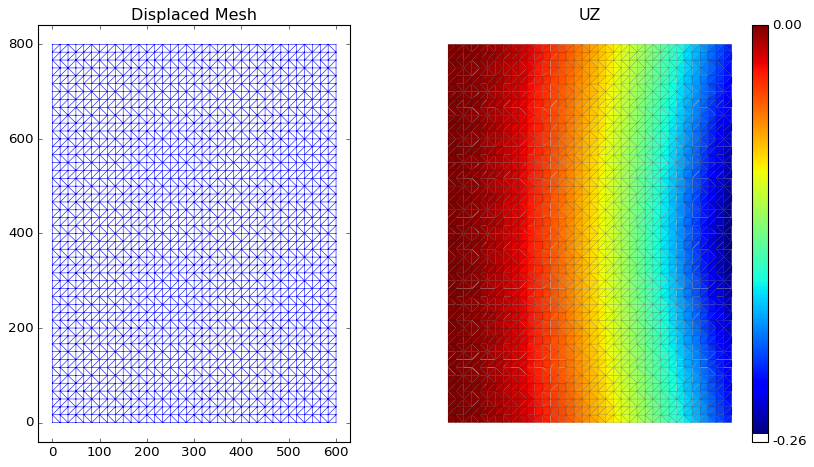

In [10]:
fig = plt.figure(figsize=(12, 6))  # in inches
fig.patch.set_facecolor("white")
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
triplot(triobj, ax=ax1, fig=fig)
triplot(triobj, ax=ax2, fig=fig, data=dofsol[:, 2], cmap="jet", axis="off")
fig.tight_layout()
ax1.set_title("Displaced Mesh")
ax2.set_title("UZ")
fig.tight_layout()